In [53]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, NLopt, Dierckx, BlackBoxOptim, Statistics
import Calculus
import GR
FF = FractionalFlow

Main.FractionalFlow

## Note
For the tertiary low salinity water flooding, the recovery factor is calculated by 
$$R_{tert}=\frac{S_{w,avg}-(1-S_{or,hs})}{S_{or,hs}}$$
However, the recovery factor is usually reported as the percentage of the initial oil that is in the reservoir before the secondary formation water water flooding, i.e.,
$$R=\frac{S_{w,avg}-S_{w,init}}{1-S_{w,init}}$$
To convert one to the other, we can write
$$R=\frac{\left(R_{tert}S_{or,hs}+(1-S_{or,hs})\right)-S_{w,init}}{1-S_{w,init}}$$
We can also do it the other way around, i.e.,
$$R_{tert}=\frac{R\left(1-S_{w,init}\right)+S_{w,init}-\left(1-S_{or,hs}\right)}{S_{or,hs}}$$

# Tertiary Water-flooding

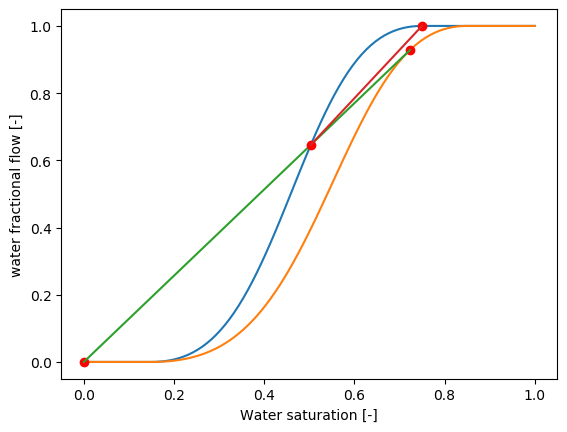

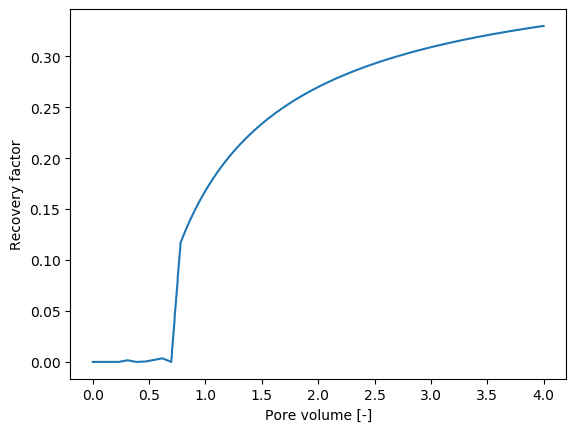

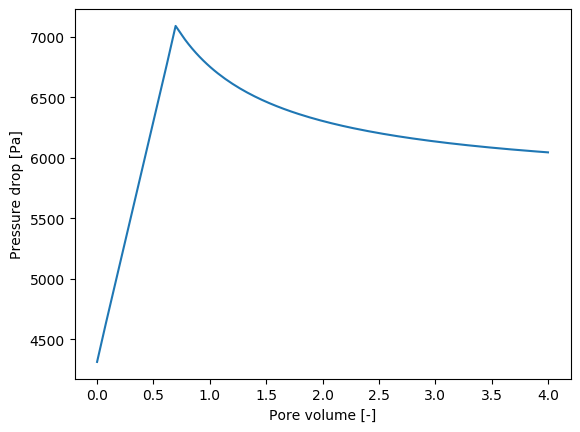

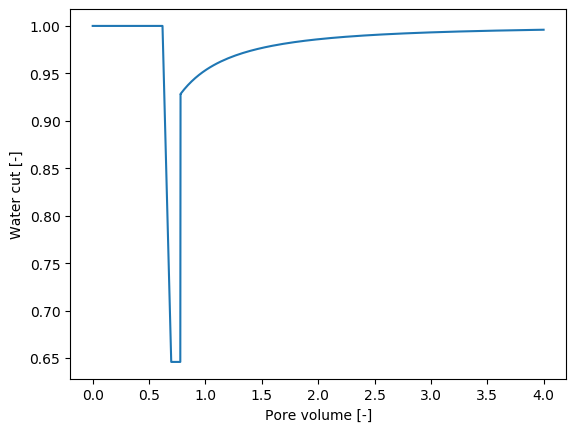

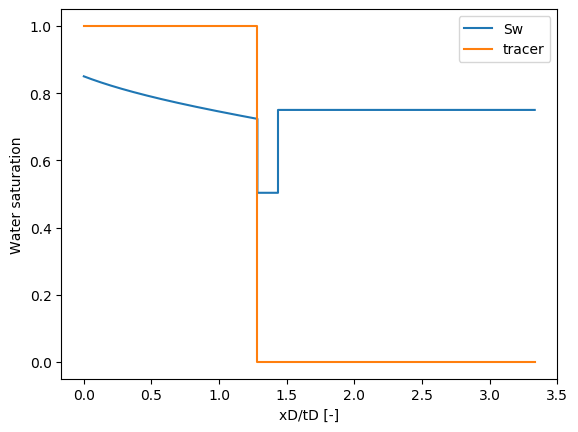

PyObject <matplotlib.legend.Legend object at 0x0000000004D5C748>

In [54]:
# define the problem
sw0 = 0.15 # initial condition of the experiment
sor_hs = 0.25 # high salinity (formation water) residual oil saturation
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=4.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(wf_res)

# synthetic experimental data
Here I scale the calculated recovery data to the total recovery data for a core initially saturated with oil at a saturation close to the connate water saturation, and secondary flooded with formation water.

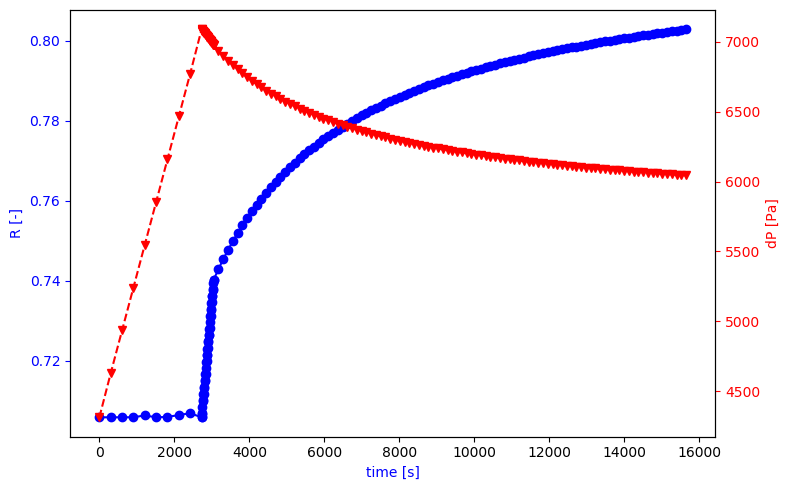

(Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000003BB508D0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000003B9F4DA0>)

In [55]:
R_exp = (wf_res.recovery_time[:,2].*sor_hs.+(1-sor_hs).-sw0)./(1.0-sw0)
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
# R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

Later, we need to convert the above data back to the tertiary recovery factor, as if the core flooding experiments starts with a core saturated with $S_{or,hs}$ oil saturation.

# define the objective function

In [56]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end

# convert the recovery data
R_conv = (R_exp.*(1-sw0).+sw0.-(1-sor_hs))/sor_hs
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_conv);

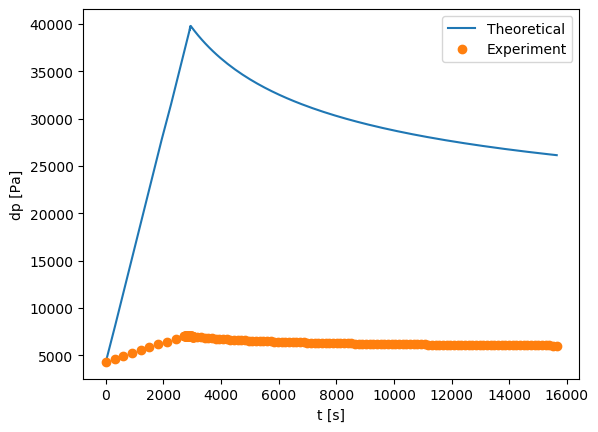

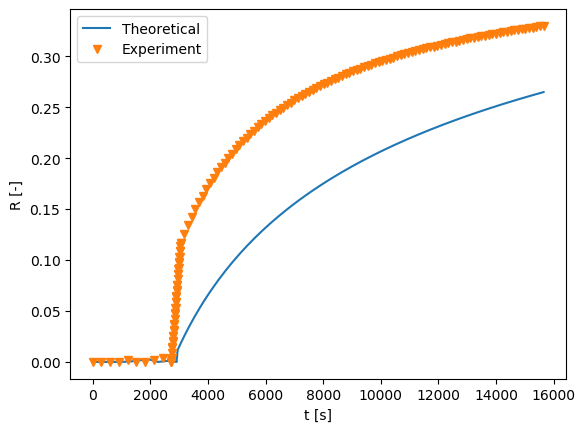

3.9618511090093786

In [57]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids_ls, fluids_hs, 
        rel_perms_hs, core_flood; w_p=1.0, w_R=1.0)
    rel_perms_ls = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R #./(exp_data.R_exp+eps()) # to avoid division by a small number
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids_ls, fluids_hs, 
        rel_perms_hs, core_flood)
    rel_perms_ls = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 3.0, 0.19, 0.1]

vis_error(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)
error_calc(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)

# define the objective function and gradients and weight factors

In [58]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
temp_val, ind_max = findmax(exp_data1.dp_exp)
w_p[ind_max-1:ind_max+2] .= 10
w_p[end:end-5] .= 10
w_p[1] = 10
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] .= 10
w_R[end:end-5] .= 10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids_ls, fluids_hs, 
            rel_perms_hs, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-4
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.1, 0.1], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.1])

0.847348832234076

In [59]:
x_init = [0.9, 0.8, 2.5, 2.5, 0.1, 0.1]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.1]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]

res = bboptimize(f, SearchRange = [(0.1, 1.0), (0.1, 1.0), (1.5, 4.0), (1.5, 4.0), 
        (0.05, core_flood.initial_water_saturation), (0.1, 0.25)])

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 20 evals, 10 steps, improv/step: 0.700 (last = 0.7000), fitness=0.130354101
1.06 secs, 49 evals, 27 steps, improv/step: 0.519 (last = 0.4118), fitness=0.130354101
1.61 secs, 77 evals, 44 steps, improv/step: 0.523 (last = 0.5294), fitness=0.130354101
2.11 secs, 109 evals, 64 steps, improv/step: 0.516 (last = 0.5000), fitness=0.123901856
2.62 secs, 136 evals, 82 steps, improv/step: 0.537 (last = 0.6111), fitness=0.123901856
3.16 secs, 164 evals, 102 steps, improv/step: 0.520 (last = 0.4500), fitness=0.123901856
3.71 secs, 189 evals, 119 steps, improv/step: 0.555 (last = 0.7647), fitness=0.123901856
4.23 secs, 215 evals, 140 steps, improv/step: 0.529 (last = 0.3810), fitness=0.123901856
4.76 secs, 242 evals, 163 steps, improv/step: 0.497 (last = 0.3043), fitness=0.084346110
5.28 s

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (10000) reached", 10001, 1.575553392093e9, 162.67700004577637, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 123340,:SearchRange => Tuple{Float64,Float64}[(0.1, 1.0), (0.1, 1.0), (1.5, 4.0), (1.5, 4.0), (0.05, 0.75), (0.1, 0.25)],:MaxSteps => 10000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 10229, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(0.00012237477101998878, [0.3000879389994999, 0.8849316302413965, 1.9179287750262926, 2.004615109299689, 0.17631265498980495, 0.1498405834595154]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Floa

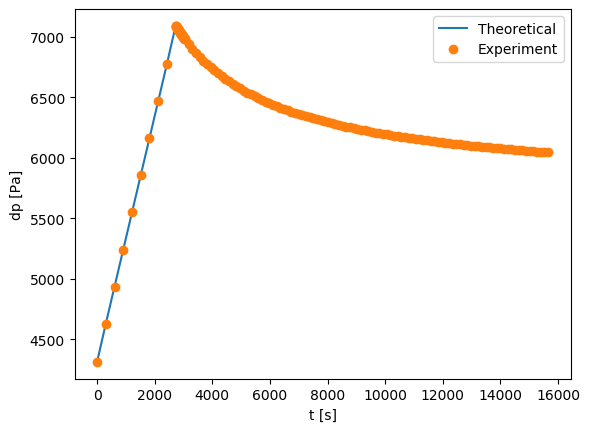

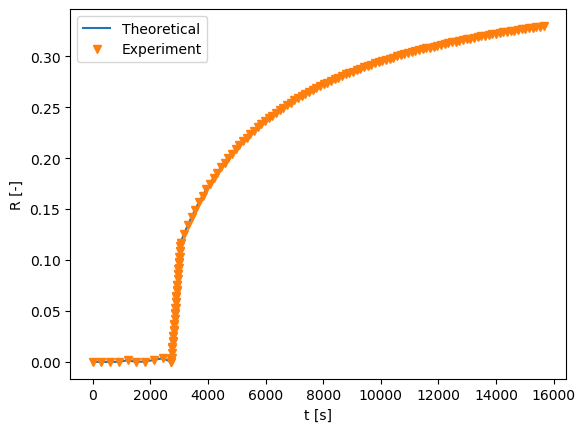

8.03717989215052e-5

In [60]:
x_init = best_candidate(res)
vis_error(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)
error_calc(x_init, exp_data1, core_props, fluids_ls, fluids_hs, rel_perms_hs, core_flood)